In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
tb=SummaryWriter()
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
bs = 32
# Load Data
train_dataset = datasets.ImageFolder(root='./No_Image_Preprocessing_Pattern1/Training/Normal', transform=transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(), 
]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False)
len(train_dataset.imgs), len(train_dataloader)
train_dataset

Dataset ImageFolder
    Number of datapoints: 256
    Root location: ./No_Image_Preprocessing_Pattern1/Training/Normal
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

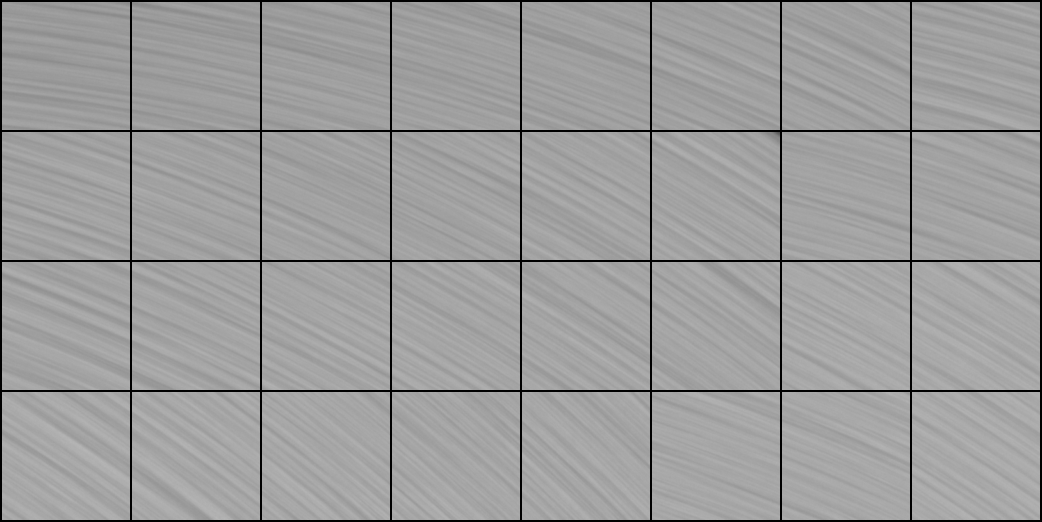

In [5]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_dataloader))
save_image(fixed_x, 'VAE_Training.png')

Image('VAE_Training.png')

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [8]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=2, stride=2),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=2, stride=2),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
image_channels = fixed_x.size(1)
image_channels

3

In [10]:
model = VAE(image_channels=image_channels)
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_run

In [11]:
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             416
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           8,256
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          32,896
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         131,328
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]         524,800
      BatchNorm2d-14            [-1, 51

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def loss_fn(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x, size_average=False).to(device)
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()).to(device)
    return MSE + KLD, MSE, KLD

In [16]:
epochs = 3000

In [15]:
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 128, 128)
    return x

In [17]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(train_dataloader):
        images, _=images.cuda(), _.cuda()
        recon_images, mu, logvar = model(images)
        loss, mse, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, epochs, loss.data, mse.data, kld.data)
    tb.add_scalar("Loss/Epoch", loss.data, epoch+1)
    tb.add_scalar("MSE/Epoch", mse.data, epoch+1)
    tb.add_scalar("KLD/Epoch", kld.data, epoch+1)
    print(to_print)
    if epoch % 100 == 0:
        pic = to_img(recon_images.cpu().data)
        save_image(pic, './No_Image_Preprocessing_Pattern1/Reconstructed/VAE/VAE_latent64_{}.png'.format(epoch))

torch.save(model.state_dict(), './autoencoder_VAE_latent64_Thesis_Pattern1.pth')

Epoch[1/3000] Loss: 35574.316 35462.793 111.523
Epoch[2/3000] Loss: 35645.941 35643.301 2.639
Epoch[3/3000] Loss: 33017.105 33003.078 14.027
Epoch[4/3000] Loss: 31571.209 31414.574 156.635
Epoch[5/3000] Loss: 30593.850 30590.771 3.078
Epoch[6/3000] Loss: 29635.863 29634.396 1.467
Epoch[7/3000] Loss: 28394.236 28392.873 1.364
Epoch[8/3000] Loss: 27103.051 27101.658 1.393
Epoch[9/3000] Loss: 26236.475 26235.156 1.318
Epoch[10/3000] Loss: 25420.773 25419.406 1.368
Epoch[11/3000] Loss: 24648.131 24646.727 1.405
Epoch[12/3000] Loss: 23904.549 23903.051 1.498
Epoch[13/3000] Loss: 23194.998 23193.543 1.456
Epoch[14/3000] Loss: 22499.707 22498.293 1.414
Epoch[15/3000] Loss: 21831.115 21829.686 1.430
Epoch[16/3000] Loss: 21183.459 21182.033 1.426
Epoch[17/3000] Loss: 20556.014 20554.586 1.427
Epoch[18/3000] Loss: 19946.742 19945.309 1.433
Epoch[19/3000] Loss: 19354.137 19352.695 1.441
Epoch[20/3000] Loss: 18778.768 18777.324 1.444
Epoch[21/3000] Loss: 18219.797 18218.367 1.430
Epoch[22/3000] Lo

Epoch[179/3000] Loss: 1148.005 1112.337 35.668
Epoch[180/3000] Loss: 1146.732 1111.238 35.494
Epoch[181/3000] Loss: 1155.552 1120.233 35.319
Epoch[182/3000] Loss: 1150.940 1115.775 35.165
Epoch[183/3000] Loss: 1153.427 1118.433 34.994
Epoch[184/3000] Loss: 1153.870 1119.067 34.803
Epoch[185/3000] Loss: 1156.387 1121.747 34.640
Epoch[186/3000] Loss: 1156.603 1122.151 34.451
Epoch[187/3000] Loss: 1161.445 1127.222 34.223
Epoch[188/3000] Loss: 1161.621 1127.512 34.109
Epoch[189/3000] Loss: 1162.145 1128.244 33.901
Epoch[190/3000] Loss: 1166.335 1132.666 33.668
Epoch[191/3000] Loss: 1163.739 1130.180 33.559
Epoch[192/3000] Loss: 1166.079 1132.758 33.321
Epoch[193/3000] Loss: 1165.060 1131.959 33.101
Epoch[194/3000] Loss: 1166.377 1133.418 32.959
Epoch[195/3000] Loss: 1169.241 1136.441 32.800
Epoch[196/3000] Loss: 1171.033 1138.461 32.571
Epoch[197/3000] Loss: 1171.302 1138.845 32.457
Epoch[198/3000] Loss: 1170.319 1137.978 32.342
Epoch[199/3000] Loss: 1172.625 1140.552 32.073
Epoch[200/300

Epoch[359/3000] Loss: 938.619 928.586 10.034
Epoch[360/3000] Loss: 941.597 931.686 9.911
Epoch[361/3000] Loss: 942.117 932.342 9.774
Epoch[362/3000] Loss: 938.492 928.744 9.748
Epoch[363/3000] Loss: 940.483 930.770 9.713
Epoch[364/3000] Loss: 939.648 929.921 9.727
Epoch[365/3000] Loss: 941.654 932.004 9.650
Epoch[366/3000] Loss: 945.171 935.679 9.493
Epoch[367/3000] Loss: 939.401 929.988 9.414
Epoch[368/3000] Loss: 940.632 931.201 9.431
Epoch[369/3000] Loss: 937.062 927.654 9.408
Epoch[370/3000] Loss: 940.243 930.922 9.321
Epoch[371/3000] Loss: 943.264 934.085 9.178
Epoch[372/3000] Loss: 936.187 927.028 9.158
Epoch[373/3000] Loss: 940.463 931.288 9.174
Epoch[374/3000] Loss: 934.980 925.843 9.137
Epoch[375/3000] Loss: 939.362 930.326 9.036
Epoch[376/3000] Loss: 940.763 931.828 8.935
Epoch[377/3000] Loss: 934.653 925.742 8.911
Epoch[378/3000] Loss: 934.751 925.874 8.877
Epoch[379/3000] Loss: 933.786 924.960 8.826
Epoch[380/3000] Loss: 936.441 927.719 8.722
Epoch[381/3000] Loss: 934.978 9

Epoch[545/3000] Loss: 793.925 789.864 4.061
Epoch[546/3000] Loss: 786.081 782.001 4.080
Epoch[547/3000] Loss: 785.684 781.614 4.070
Epoch[548/3000] Loss: 783.740 779.693 4.047
Epoch[549/3000] Loss: 794.345 790.323 4.022
Epoch[550/3000] Loss: 792.934 789.043 3.890
Epoch[551/3000] Loss: 787.093 783.140 3.953
Epoch[552/3000] Loss: 787.353 783.354 3.999
Epoch[553/3000] Loss: 782.835 778.874 3.961
Epoch[554/3000] Loss: 801.208 797.370 3.838
Epoch[555/3000] Loss: 780.956 777.122 3.834
Epoch[556/3000] Loss: 791.220 787.306 3.914
Epoch[557/3000] Loss: 774.800 770.890 3.910
Epoch[558/3000] Loss: 789.592 785.770 3.822
Epoch[559/3000] Loss: 787.882 784.075 3.807
Epoch[560/3000] Loss: 778.315 774.453 3.862
Epoch[561/3000] Loss: 773.040 769.194 3.846
Epoch[562/3000] Loss: 778.823 774.987 3.836
Epoch[563/3000] Loss: 782.397 778.659 3.738
Epoch[564/3000] Loss: 772.919 769.147 3.772
Epoch[565/3000] Loss: 767.405 763.597 3.809
Epoch[566/3000] Loss: 772.890 769.030 3.860
Epoch[567/3000] Loss: 777.706 77

Epoch[732/3000] Loss: 640.335 637.347 2.988
Epoch[733/3000] Loss: 641.399 638.312 3.086
Epoch[734/3000] Loss: 627.476 624.422 3.054
Epoch[735/3000] Loss: 643.945 640.937 3.008
Epoch[736/3000] Loss: 645.834 642.827 3.007
Epoch[737/3000] Loss: 645.155 642.076 3.079
Epoch[738/3000] Loss: 624.389 621.331 3.058
Epoch[739/3000] Loss: 640.685 637.625 3.060
Epoch[740/3000] Loss: 635.143 632.062 3.081
Epoch[741/3000] Loss: 626.834 623.801 3.034
Epoch[742/3000] Loss: 618.495 615.417 3.078
Epoch[743/3000] Loss: 614.164 611.036 3.128
Epoch[744/3000] Loss: 617.560 614.484 3.075
Epoch[745/3000] Loss: 611.346 608.250 3.095
Epoch[746/3000] Loss: 598.157 595.055 3.102
Epoch[747/3000] Loss: 592.470 589.392 3.078
Epoch[748/3000] Loss: 588.688 585.611 3.076
Epoch[749/3000] Loss: 587.788 584.660 3.128
Epoch[750/3000] Loss: 584.766 581.668 3.098
Epoch[751/3000] Loss: 587.661 584.597 3.063
Epoch[752/3000] Loss: 606.582 603.482 3.100
Epoch[753/3000] Loss: 614.429 611.340 3.090
Epoch[754/3000] Loss: 609.785 60

Epoch[919/3000] Loss: 292.565 288.338 4.227
Epoch[920/3000] Loss: 288.307 284.132 4.175
Epoch[921/3000] Loss: 287.504 283.339 4.165
Epoch[922/3000] Loss: 284.762 280.584 4.178
Epoch[923/3000] Loss: 280.213 276.066 4.147
Epoch[924/3000] Loss: 283.567 279.449 4.118
Epoch[925/3000] Loss: 280.748 276.603 4.145
Epoch[926/3000] Loss: 279.798 275.665 4.133
Epoch[927/3000] Loss: 279.683 275.577 4.106
Epoch[928/3000] Loss: 277.071 272.947 4.124
Epoch[929/3000] Loss: 278.010 273.909 4.101
Epoch[930/3000] Loss: 277.612 273.533 4.079
Epoch[931/3000] Loss: 275.303 271.230 4.073
Epoch[932/3000] Loss: 274.491 270.386 4.105
Epoch[933/3000] Loss: 273.466 269.379 4.087
Epoch[934/3000] Loss: 278.441 274.379 4.062
Epoch[935/3000] Loss: 273.947 269.917 4.031
Epoch[936/3000] Loss: 275.591 271.549 4.042
Epoch[937/3000] Loss: 276.603 272.560 4.042
Epoch[938/3000] Loss: 272.423 268.372 4.051
Epoch[939/3000] Loss: 282.758 278.735 4.023
Epoch[940/3000] Loss: 278.378 274.327 4.051
Epoch[941/3000] Loss: 288.375 28

Epoch[1103/3000] Loss: 226.691 223.010 3.682
Epoch[1104/3000] Loss: 224.835 221.123 3.712
Epoch[1105/3000] Loss: 227.766 224.081 3.685
Epoch[1106/3000] Loss: 228.318 224.652 3.666
Epoch[1107/3000] Loss: 225.724 222.057 3.667
Epoch[1108/3000] Loss: 228.036 224.383 3.654
Epoch[1109/3000] Loss: 229.737 226.072 3.665
Epoch[1110/3000] Loss: 234.273 230.599 3.674
Epoch[1111/3000] Loss: 229.943 226.265 3.678
Epoch[1112/3000] Loss: 233.983 230.293 3.689
Epoch[1113/3000] Loss: 232.164 228.450 3.714
Epoch[1114/3000] Loss: 239.101 235.370 3.732
Epoch[1115/3000] Loss: 230.194 226.474 3.719
Epoch[1116/3000] Loss: 232.480 228.740 3.741
Epoch[1117/3000] Loss: 230.855 227.090 3.764
Epoch[1118/3000] Loss: 232.212 228.497 3.715
Epoch[1119/3000] Loss: 229.522 225.800 3.722
Epoch[1120/3000] Loss: 228.260 224.512 3.748
Epoch[1121/3000] Loss: 228.162 224.439 3.723
Epoch[1122/3000] Loss: 234.925 231.212 3.713
Epoch[1123/3000] Loss: 228.819 225.128 3.691
Epoch[1124/3000] Loss: 234.883 231.160 3.722
Epoch[1125

Epoch[1286/3000] Loss: 216.665 213.292 3.373
Epoch[1287/3000] Loss: 218.671 215.296 3.374
Epoch[1288/3000] Loss: 215.318 211.894 3.424
Epoch[1289/3000] Loss: 218.541 215.123 3.418
Epoch[1290/3000] Loss: 218.155 214.776 3.379
Epoch[1291/3000] Loss: 215.918 212.457 3.461
Epoch[1292/3000] Loss: 214.668 211.225 3.443
Epoch[1293/3000] Loss: 216.458 213.023 3.435
Epoch[1294/3000] Loss: 216.480 213.028 3.452
Epoch[1295/3000] Loss: 213.833 210.396 3.438
Epoch[1296/3000] Loss: 216.553 213.052 3.501
Epoch[1297/3000] Loss: 218.598 215.114 3.484
Epoch[1298/3000] Loss: 220.602 217.162 3.440
Epoch[1299/3000] Loss: 221.363 217.877 3.486
Epoch[1300/3000] Loss: 228.953 225.554 3.399
Epoch[1301/3000] Loss: 272.257 268.840 3.416
Epoch[1302/3000] Loss: 366.171 362.626 3.545
Epoch[1303/3000] Loss: 303.794 299.976 3.817
Epoch[1304/3000] Loss: 373.700 369.454 4.246
Epoch[1305/3000] Loss: 418.499 413.925 4.575
Epoch[1306/3000] Loss: 326.704 322.171 4.534
Epoch[1307/3000] Loss: 313.810 309.003 4.808
Epoch[1308

Epoch[1469/3000] Loss: 203.680 200.308 3.372
Epoch[1470/3000] Loss: 202.909 199.507 3.402
Epoch[1471/3000] Loss: 203.535 200.130 3.405
Epoch[1472/3000] Loss: 203.716 200.261 3.454
Epoch[1473/3000] Loss: 204.517 201.088 3.429
Epoch[1474/3000] Loss: 204.301 200.885 3.416
Epoch[1475/3000] Loss: 208.867 205.396 3.472
Epoch[1476/3000] Loss: 206.912 203.462 3.449
Epoch[1477/3000] Loss: 203.263 199.828 3.436
Epoch[1478/3000] Loss: 204.876 201.430 3.446
Epoch[1479/3000] Loss: 203.050 199.604 3.446
Epoch[1480/3000] Loss: 202.087 198.651 3.436
Epoch[1481/3000] Loss: 201.640 198.215 3.425
Epoch[1482/3000] Loss: 201.486 198.056 3.430
Epoch[1483/3000] Loss: 202.340 198.936 3.404
Epoch[1484/3000] Loss: 201.063 197.690 3.373
Epoch[1485/3000] Loss: 203.019 199.623 3.396
Epoch[1486/3000] Loss: 204.491 201.103 3.388
Epoch[1487/3000] Loss: 203.115 199.754 3.361
Epoch[1488/3000] Loss: 203.707 200.369 3.338
Epoch[1489/3000] Loss: 202.007 198.621 3.386
Epoch[1490/3000] Loss: 205.336 201.984 3.352
Epoch[1491

Epoch[1652/3000] Loss: 192.160 189.186 2.974
Epoch[1653/3000] Loss: 191.385 188.420 2.965
Epoch[1654/3000] Loss: 193.496 190.525 2.971
Epoch[1655/3000] Loss: 193.736 190.763 2.972
Epoch[1656/3000] Loss: 198.466 195.489 2.977
Epoch[1657/3000] Loss: 197.350 194.341 3.009
Epoch[1658/3000] Loss: 201.701 198.682 3.018
Epoch[1659/3000] Loss: 199.184 196.146 3.039
Epoch[1660/3000] Loss: 199.665 196.646 3.020
Epoch[1661/3000] Loss: 199.012 196.027 2.985
Epoch[1662/3000] Loss: 199.630 196.555 3.075
Epoch[1663/3000] Loss: 197.073 194.049 3.024
Epoch[1664/3000] Loss: 199.735 196.758 2.977
Epoch[1665/3000] Loss: 196.996 193.989 3.007
Epoch[1666/3000] Loss: 199.190 196.164 3.026
Epoch[1667/3000] Loss: 197.238 194.220 3.018
Epoch[1668/3000] Loss: 198.885 195.883 3.002
Epoch[1669/3000] Loss: 195.864 192.867 2.997
Epoch[1670/3000] Loss: 198.494 195.408 3.086
Epoch[1671/3000] Loss: 196.594 193.599 2.996
Epoch[1672/3000] Loss: 195.784 192.776 3.008
Epoch[1673/3000] Loss: 193.982 190.971 3.011
Epoch[1674

Epoch[1835/3000] Loss: 197.912 195.096 2.816
Epoch[1836/3000] Loss: 200.582 197.748 2.834
Epoch[1837/3000] Loss: 198.282 195.428 2.853
Epoch[1838/3000] Loss: 199.673 196.769 2.904
Epoch[1839/3000] Loss: 199.233 196.365 2.868
Epoch[1840/3000] Loss: 203.223 200.296 2.927
Epoch[1841/3000] Loss: 202.628 199.726 2.902
Epoch[1842/3000] Loss: 202.957 199.997 2.960
Epoch[1843/3000] Loss: 199.672 196.695 2.978
Epoch[1844/3000] Loss: 199.408 196.498 2.911
Epoch[1845/3000] Loss: 200.596 197.697 2.898
Epoch[1846/3000] Loss: 198.083 195.181 2.902
Epoch[1847/3000] Loss: 195.081 192.214 2.868
Epoch[1848/3000] Loss: 194.960 192.111 2.850
Epoch[1849/3000] Loss: 192.499 189.696 2.803
Epoch[1850/3000] Loss: 192.386 189.578 2.808
Epoch[1851/3000] Loss: 192.374 189.583 2.791
Epoch[1852/3000] Loss: 193.001 190.227 2.774
Epoch[1853/3000] Loss: 193.566 190.811 2.754
Epoch[1854/3000] Loss: 191.508 188.741 2.767
Epoch[1855/3000] Loss: 194.437 191.679 2.758
Epoch[1856/3000] Loss: 192.778 190.026 2.753
Epoch[1857

Epoch[2018/3000] Loss: 187.757 185.259 2.498
Epoch[2019/3000] Loss: 188.439 185.936 2.504
Epoch[2020/3000] Loss: 186.537 184.069 2.468
Epoch[2021/3000] Loss: 187.203 184.724 2.479
Epoch[2022/3000] Loss: 187.023 184.562 2.461
Epoch[2023/3000] Loss: 186.658 184.187 2.471
Epoch[2024/3000] Loss: 186.760 184.318 2.442
Epoch[2025/3000] Loss: 185.444 182.998 2.446
Epoch[2026/3000] Loss: 185.715 183.283 2.432
Epoch[2027/3000] Loss: 184.494 182.078 2.416
Epoch[2028/3000] Loss: 184.557 182.158 2.398
Epoch[2029/3000] Loss: 185.233 182.833 2.400
Epoch[2030/3000] Loss: 184.221 181.819 2.402
Epoch[2031/3000] Loss: 184.266 181.866 2.400
Epoch[2032/3000] Loss: 184.566 182.165 2.402
Epoch[2033/3000] Loss: 184.485 182.078 2.407
Epoch[2034/3000] Loss: 185.170 182.778 2.393
Epoch[2035/3000] Loss: 184.001 181.591 2.410
Epoch[2036/3000] Loss: 185.642 183.257 2.385
Epoch[2037/3000] Loss: 185.407 183.027 2.380
Epoch[2038/3000] Loss: 185.687 183.286 2.401
Epoch[2039/3000] Loss: 184.543 182.127 2.416
Epoch[2040

Epoch[2201/3000] Loss: 188.295 185.970 2.325
Epoch[2202/3000] Loss: 192.056 189.694 2.363
Epoch[2203/3000] Loss: 192.149 189.797 2.352
Epoch[2204/3000] Loss: 188.758 186.398 2.359
Epoch[2205/3000] Loss: 191.580 189.257 2.323
Epoch[2206/3000] Loss: 189.831 187.492 2.338
Epoch[2207/3000] Loss: 189.933 187.587 2.345
Epoch[2208/3000] Loss: 187.686 185.381 2.306
Epoch[2209/3000] Loss: 188.877 186.585 2.292
Epoch[2210/3000] Loss: 187.317 185.035 2.282
Epoch[2211/3000] Loss: 187.397 185.102 2.296
Epoch[2212/3000] Loss: 187.894 185.606 2.287
Epoch[2213/3000] Loss: 187.965 185.670 2.295
Epoch[2214/3000] Loss: 188.131 185.809 2.321
Epoch[2215/3000] Loss: 189.794 187.485 2.309
Epoch[2216/3000] Loss: 189.474 187.177 2.296
Epoch[2217/3000] Loss: 190.837 188.571 2.266
Epoch[2218/3000] Loss: 188.977 186.701 2.276
Epoch[2219/3000] Loss: 189.401 187.119 2.282
Epoch[2220/3000] Loss: 187.743 185.489 2.254
Epoch[2221/3000] Loss: 188.142 185.886 2.256
Epoch[2222/3000] Loss: 188.761 186.497 2.264
Epoch[2223

Epoch[2384/3000] Loss: 181.601 179.537 2.064
Epoch[2385/3000] Loss: 180.975 178.938 2.037
Epoch[2386/3000] Loss: 180.677 178.598 2.079
Epoch[2387/3000] Loss: 180.896 178.814 2.082
Epoch[2388/3000] Loss: 180.987 178.891 2.095
Epoch[2389/3000] Loss: 180.678 178.551 2.126
Epoch[2390/3000] Loss: 180.042 177.925 2.117
Epoch[2391/3000] Loss: 180.646 178.511 2.135
Epoch[2392/3000] Loss: 179.427 177.295 2.132
Epoch[2393/3000] Loss: 179.561 177.428 2.133
Epoch[2394/3000] Loss: 178.695 176.584 2.111
Epoch[2395/3000] Loss: 179.323 177.207 2.116
Epoch[2396/3000] Loss: 180.197 178.105 2.092
Epoch[2397/3000] Loss: 179.429 177.335 2.094
Epoch[2398/3000] Loss: 179.197 177.135 2.062
Epoch[2399/3000] Loss: 179.200 177.136 2.064
Epoch[2400/3000] Loss: 179.677 177.618 2.059
Epoch[2401/3000] Loss: 180.795 178.742 2.053
Epoch[2402/3000] Loss: 179.994 177.952 2.042
Epoch[2403/3000] Loss: 180.641 178.621 2.019
Epoch[2404/3000] Loss: 178.329 176.299 2.030
Epoch[2405/3000] Loss: 178.360 176.339 2.021
Epoch[2406

Epoch[2567/3000] Loss: 183.205 181.273 1.933
Epoch[2568/3000] Loss: 181.471 179.552 1.919
Epoch[2569/3000] Loss: 181.325 179.393 1.932
Epoch[2570/3000] Loss: 181.171 179.263 1.909
Epoch[2571/3000] Loss: 179.963 178.053 1.910
Epoch[2572/3000] Loss: 182.107 180.188 1.919
Epoch[2573/3000] Loss: 180.954 179.041 1.913
Epoch[2574/3000] Loss: 182.744 180.837 1.906
Epoch[2575/3000] Loss: 180.867 178.959 1.908
Epoch[2576/3000] Loss: 180.672 178.763 1.909
Epoch[2577/3000] Loss: 182.117 180.205 1.911
Epoch[2578/3000] Loss: 180.265 178.359 1.907
Epoch[2579/3000] Loss: 180.520 178.612 1.908
Epoch[2580/3000] Loss: 179.843 177.924 1.919
Epoch[2581/3000] Loss: 182.243 180.325 1.918
Epoch[2582/3000] Loss: 184.155 182.255 1.901
Epoch[2583/3000] Loss: 183.038 181.121 1.917
Epoch[2584/3000] Loss: 184.188 182.253 1.935
Epoch[2585/3000] Loss: 183.761 181.834 1.927
Epoch[2586/3000] Loss: 184.585 182.650 1.935
Epoch[2587/3000] Loss: 183.858 181.923 1.936
Epoch[2588/3000] Loss: 184.619 182.674 1.945
Epoch[2589

Epoch[2750/3000] Loss: 186.485 184.226 2.260
Epoch[2751/3000] Loss: 186.344 184.187 2.157
Epoch[2752/3000] Loss: 186.002 183.785 2.217
Epoch[2753/3000] Loss: 186.571 184.465 2.106
Epoch[2754/3000] Loss: 184.831 182.664 2.167
Epoch[2755/3000] Loss: 182.484 180.368 2.117
Epoch[2756/3000] Loss: 181.990 179.857 2.133
Epoch[2757/3000] Loss: 180.267 178.173 2.094
Epoch[2758/3000] Loss: 180.576 178.523 2.053
Epoch[2759/3000] Loss: 179.298 177.278 2.021
Epoch[2760/3000] Loss: 179.919 177.912 2.008
Epoch[2761/3000] Loss: 179.346 177.352 1.994
Epoch[2762/3000] Loss: 177.718 175.748 1.970
Epoch[2763/3000] Loss: 178.992 177.037 1.955
Epoch[2764/3000] Loss: 178.000 176.051 1.949
Epoch[2765/3000] Loss: 177.429 175.490 1.939
Epoch[2766/3000] Loss: 176.761 174.837 1.924
Epoch[2767/3000] Loss: 175.730 173.805 1.925
Epoch[2768/3000] Loss: 176.277 174.361 1.916
Epoch[2769/3000] Loss: 175.013 173.109 1.904
Epoch[2770/3000] Loss: 174.881 172.983 1.898
Epoch[2771/3000] Loss: 174.370 172.481 1.889
Epoch[2772

Epoch[2933/3000] Loss: 179.470 177.704 1.766
Epoch[2934/3000] Loss: 177.216 175.454 1.762
Epoch[2935/3000] Loss: 177.878 176.112 1.767
Epoch[2936/3000] Loss: 176.171 174.397 1.774
Epoch[2937/3000] Loss: 176.798 175.035 1.763
Epoch[2938/3000] Loss: 174.528 172.760 1.767
Epoch[2939/3000] Loss: 174.874 173.067 1.807
Epoch[2940/3000] Loss: 174.477 172.669 1.808
Epoch[2941/3000] Loss: 173.729 171.932 1.798
Epoch[2942/3000] Loss: 173.457 171.668 1.789
Epoch[2943/3000] Loss: 172.258 170.435 1.822
Epoch[2944/3000] Loss: 173.590 171.776 1.813
Epoch[2945/3000] Loss: 172.172 170.360 1.812
Epoch[2946/3000] Loss: 173.532 171.723 1.810
Epoch[2947/3000] Loss: 175.029 173.230 1.799
Epoch[2948/3000] Loss: 176.288 174.494 1.794
Epoch[2949/3000] Loss: 175.268 173.488 1.780
Epoch[2950/3000] Loss: 174.363 172.576 1.788
Epoch[2951/3000] Loss: 173.957 172.181 1.776
Epoch[2952/3000] Loss: 173.789 172.025 1.764
Epoch[2953/3000] Loss: 172.950 171.185 1.764
Epoch[2954/3000] Loss: 173.368 171.620 1.749
Epoch[2955

In [18]:
tb.flush()